In [1]:
#importing packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import nltk
import datetime
from os import path
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from datetime import datetime
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score, mean_squared_error, confusion_matrix, classification_report, f1_score, roc_auc_score
from dateutil.relativedelta import relativedelta
from scipy.stats import f_oneway, ttest_ind, chi2_contingency
from pycaret.classification import *
from lightgbm import LGBMClassifier

Importing DataBase

In [2]:
statd = pd.read_csv("statd.csv")

In [3]:
statd = statd.fillna('N/A')

In [4]:
statd = statd.query("smokes != 'N/A'")

In [5]:
statd.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,height,income,...,pacific islander,native american,middle eastern,indian,location,sign,religion,education,offspring,lang_spoken
0,22,single,m,straight,a little extra,anything,socially,never,190.0,104319.248826,...,0,0,0,0,california,gemini,agnosticism,Not Graduated,No Kids,1
1,35,single,m,straight,average,other,often,sometimes,178.0,80000.000000,...,0,0,0,0,california,cancer,agnosticism,Not Graduated,No Kids,3
2,38,available,m,straight,thin,anything,socially,N/A,173.0,104319.248826,...,0,0,0,0,california,pisces,N/A,Post Graduate,N/A,3
3,23,single,m,straight,thin,vegetarian,socially,N/A,180.0,20000.000000,...,0,0,0,0,california,pisces,N/A,Not Graduated,No Kids,2
4,29,single,m,straight,athletic,N/A,socially,never,168.0,104319.248826,...,0,0,0,0,california,aquarius,N/A,Graduated,N/A,1


In [6]:
statd.dtypes

age                   int64
status               object
sex                  object
orientation          object
body_type            object
diet                 object
drinks               object
drugs                object
height              float64
income              float64
job                  object
smokes               object
asian                 int64
white                 int64
black                 int64
other                 int64
hispanic / latin      int64
pacific islander      int64
native american       int64
middle eastern        int64
indian                int64
location             object
sign                 object
religion             object
education            object
offspring            object
lang_spoken           int64
dtype: object

PyCaret Analysis for the best possible label choice

In [7]:
s = setup(statd, target = 'smokes', categorical_features = ['status', 'sex', 'orientation', 'body_type', 'diet', 'drinks', 'drugs', 'job', 'asian', 'white', 'black', 'other', 'hispanic / latin', 'pacific islander', 'native american', 'middle eastern', 'indian', 'location', 'sign', 'religion', 'education', 'offspring'], numeric_features = ['height', 'income', 'age', 'lang_spoken'], ordinal_features = None, remove_outliers = True, session_id = 1312)

,Description,Value
0,Session id,1312
1,Target,smokes
2,Target type,Multiclass
3,Target mapping,"no: 0, sometimes: 1, trying to quit: 2, when drinking: 3, yes: 4"
4,Original data shape,"(54427, 27)"
5,Transformed data shape,"(52522, 106)"
6,Transformed train set shape,"(36193, 106)"
7,Transformed test set shape,"(16329, 106)"
8,Ordinal features,10
9,Numeric features,4


In [8]:
best_sm = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8075,0.0000,0.8075,0.6825,0.7271,0.0379,0.0999,4.7160
rf,Random Forest Classifier,0.8070,0.7556,0.8070,0.7053,0.7288,0.0468,0.1065,6.9510
gbc,Gradient Boosting Classifier,0.8069,0.7765,0.8069,0.7082,0.7346,0.0832,0.1430,19.1550
ada,Ada Boost Classifier,0.8068,0.7522,0.8068,0.7102,0.7350,0.0898,0.1489,5.6560
lr,Logistic Regression,0.8064,0.5943,0.8064,0.6504,0.7200,0.0000,0.0000,8.1870
svm,SVM - Linear Kernel,0.8064,0.0000,0.8064,0.6504,0.7200,0.0000,0.0000,5.5300
dummy,Dummy Classifier,0.8064,0.5000,0.8064,0.6504,0.7200,0.0000,0.0000,4.5960
lightgbm,Light Gradient Boosting Machine,0.8062,0.7728,0.8062,0.6997,0.7340,0.0815,0.1386,5.9960
et,Extra Trees Classifier,0.8042,0.7439,0.8042,0.6989,0.7320,0.0712,0.1212,8.2830
nb,Naive Bayes,0.8016,0.6537,0.8016,0.6560,0.7201,0.0108,0.0277,4.9720


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [9]:
evaluate_model(best_sm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Creating the 2 dataframes we are going to use throughout the analysis: the inputs and the label

In [7]:
statd.isna().sum()

age                 0
status              0
sex                 0
orientation         0
body_type           0
diet                0
drinks              0
drugs               0
height              0
income              0
job                 0
smokes              0
asian               0
white               0
black               0
other               0
hispanic / latin    0
pacific islander    0
native american     0
middle eastern      0
indian              0
location            0
sign                0
religion            0
education           0
offspring           0
lang_spoken         0
dtype: int64

In [6]:
label = statd["smokes"]
statd2 = statd.drop("smokes", axis = 1)

In [7]:
statd2.columns

Index(['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks',
       'drugs', 'height', 'income', 'job', 'asian', 'white', 'black', 'other',
       'hispanic / latin', 'pacific islander', 'native american',
       'middle eastern', 'indian', 'location', 'sign', 'religion', 'education',
       'offspring', 'lang_spoken'],
      dtype='object')

In [8]:
statd2.columns = [col.replace(" ", "_") for col in statd2.columns]

In [9]:
#there are columns already converted to dummies, and also there are numeric type columns
#I check the rest and call pandas' get_dummies function to convert all categoric data to numeric for statistical analysis
object_columns = statd2.select_dtypes(include=['object']).columns

In [10]:
statd_objects = statd2[object_columns]
df_encoded = pd.get_dummies(statd_objects, prefix=statd_objects.columns)
df_noredundance = pd.get_dummies(statd_objects, prefix=statd_objects.columns, drop_first = True)

In [11]:
df_encoded.columns

Index(['status_available', 'status_married', 'status_seeing someone',
       'status_single', 'status_unknown', 'sex_f', 'sex_m',
       'orientation_bisexual', 'orientation_gay', 'orientation_straight',
       ...
       'religion_islam', 'religion_judaism', 'religion_other',
       'education_Graduated', 'education_N/A', 'education_Not Graduated',
       'education_Post Graduate', 'offspring_Has Kids', 'offspring_N/A',
       'offspring_No Kids'],
      dtype='object', length=128)

In [12]:
df_encoded = df_encoded.loc[:, ~df_encoded.columns.str.contains("N/A")]

In [13]:
df_noredundance = df_noredundance.loc[:, ~df_noredundance.columns.str.contains("N/A")]

In [14]:
df_encoded.shape

(54427, 120)

In [15]:
#completing our input dataset ready for analysis
numeric_df = statd[statd.select_dtypes(exclude=['object']).columns]
stat_df = pd.concat([df_encoded, numeric_df], axis = 1)

Gradient Boosting and Initial Tests for Classification Models

In [16]:
X_train, X_test, y_train, y_test = train_test_split(stat_df, label, test_size=0.3, random_state = 1312)

In [17]:
best_train_f1 = 0
best_train_auc = 0
best_n_estimators = 0
best_max_features = 0
best_max_depth = 0

for n in range(1,10):
    for m in range(2,5):
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_features=n, max_depth=m)
        model.fit(X_train, y_train)

        # Calculate F1 score for training set
        f1_train = f1_score(y_train, model.predict(X_train), average='weighted')

        # Calculate ROC-AUC score for training set
        roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')

        if f1_train > best_train_f1:
            best_train_f1 = f1_train
            best_train_auc = roc_auc_train
            best_n_estimators = 100
            best_max_features = n
            best_max_depth = m

#        if acc_val > best_val_accuracy:
#           best_val_accuracy = acc_val

# Create and train the best model using the optimal hyperparameters
best_model = GradientBoostingClassifier(n_estimators=best_n_estimators, learning_rate=0.1, max_features=best_max_features, max_depth=best_max_depth)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

print("Best Hyperparameters:")
print(f"n_estimators: {best_n_estimators}")
print(f"max_features: {best_max_features}")
print(f"max_depth: {best_max_depth}")
print("Best Train F1 Score:", best_train_f1)
print("Best Train AUC-ROC:", best_train_auc)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

Best Hyperparameters:
n_estimators: 100
max_features: 9
max_depth: 4
Best Train F1 Score: 0.7427723922353119
Best Train AUC-ROC: 0.8006753367210464
Confusion Matrix:
[[13048    15     6     4    56]
 [ 1120    10     2     3    45]
 [  436     4     0     0    16]
 [  856     2     0     1    30]
 [  586    17     1     2    69]]
Classification Report
                precision    recall  f1-score   support

            no       0.81      0.99      0.89     13129
     sometimes       0.21      0.01      0.02      1180
trying to quit       0.00      0.00      0.00       456
 when drinking       0.10      0.00      0.00       889
           yes       0.32      0.10      0.15       675

      accuracy                           0.80     16329
     macro avg       0.29      0.22      0.21     16329
  weighted avg       0.69      0.80      0.73     16329



In [18]:
feature_importances = best_model.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Create a list of feature names and their corresponding importances
feature_importance_list = list(zip(feature_names, feature_importances))

# Sort the list by importance in descending order
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

# Print the feature names and their importances
selected_features = []  # Initialize an empty list to store selected feature names
count = 0

for feature, importance in feature_importance_list:
    if importance > 0.01:
        selected_features.append(feature)  # Add the feature to the list
        print(f"Feature: {feature}, Importance: {importance}")

Feature: drugs_sometimes, Importance: 0.19303631111593
Feature: drugs_never, Importance: 0.11114926133067639
Feature: age, Importance: 0.08184304073004203
Feature: drinks_often, Importance: 0.05952786194900705
Feature: education_Post Graduate, Importance: 0.04315954975187147
Feature: drugs_often, Importance: 0.042604092320631656
Feature: education_Not Graduated, Importance: 0.038685123162738276
Feature: income, Importance: 0.03539395052820672
Feature: drinks_very often, Importance: 0.029406985247219367
Feature: education_Graduated, Importance: 0.029316399930407473
Feature: body_type_athletic, Importance: 0.014511460685011865
Feature: height, Importance: 0.014199465823773058
Feature: drinks_rarely, Importance: 0.013663825890361874
Feature: drinks_socially, Importance: 0.013179223111925717
Feature: body_type_fit, Importance: 0.012589958666329028
Feature: job_hospitality / travel, Importance: 0.011516323141948802


Statistical Analysis

In [19]:
label.describe()

count     54427
unique        5
top          no
freq      43892
Name: smokes, dtype: object

In [20]:
statd['height'].groupby(statd['smokes']).describe()

,count,mean,std,min,25%,50%,75%,max
smokes,,,,,,,,
no,43892.0,173.215324,9.914094,66.0,165.0,173.0,180.0,241.0
sometimes,3787.0,174.085820,9.993991,91.0,168.0,175.0,180.0,241.0
trying to quit,1480.0,174.917568,9.848066,107.0,168.0,175.0,183.0,211.0
when drinking,3038.0,173.963792,10.064494,135.0,168.0,175.0,180.0,241.0
yes,2230.0,174.564126,10.332262,124.0,168.0,175.0,183.0,241.0


In [21]:
statd['age'].groupby(statd['smokes']).describe()

,count,mean,std,min,25%,50%,75%,max
smokes,,,,,,,,
no,43892.0,33.312016,9.803938,18.0,26.0,31.0,38.0,69.0
sometimes,3787.0,29.377872,8.161443,18.0,24.0,27.0,33.0,69.0
trying to quit,1480.0,31.479054,8.816105,18.0,25.0,30.0,36.0,68.0
when drinking,3038.0,28.977617,6.418417,18.0,24.0,28.0,32.0,109.0
yes,2230.0,28.452018,7.789237,18.0,23.0,27.0,32.0,66.0


In [22]:
statd['income'].groupby(statd['smokes']).describe()

,count,mean,std,min,25%,50%,75%,max
smokes,,,,,,,,
no,43892.0,103504.298216,77762.836562,20000.0,104319.248826,104319.248826,104319.248826,1000000.0
sometimes,3787.0,105503.532594,121393.344796,20000.0,104319.248826,104319.248826,104319.248826,1000000.0
trying to quit,1480.0,101711.902043,118065.767435,20000.0,80000.000000,104319.248826,104319.248826,1000000.0
when drinking,3038.0,106160.202382,114909.253410,20000.0,104319.248826,104319.248826,104319.248826,1000000.0
yes,2230.0,103361.628666,132288.090735,20000.0,70000.000000,104319.248826,104319.248826,1000000.0


In [23]:
smokes_counts = statd['smokes'].value_counts()

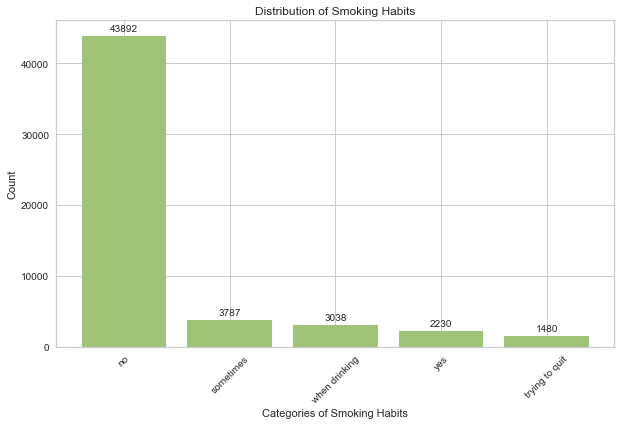

In [24]:
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.bar(smokes_counts.index, smokes_counts)

# Add labels and title
plt.xlabel('Categories of Smoking Habits')
plt.ylabel('Count')
plt.title('Distribution of Smoking Habits')
bars = plt.bar(smokes_counts.index, smokes_counts)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords='offset points', ha='center', va='bottom')


# Show the plot
plt.show()

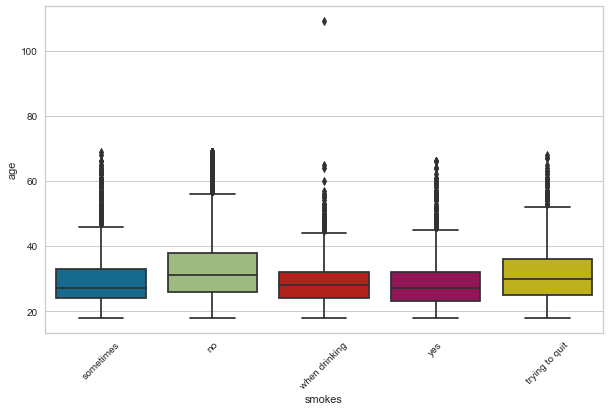

In [25]:
# Create a larger figure
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed
plt.xticks(rotation=45)
# Create the boxplot
sns.boxplot(x='smokes', y='age', data=statd)

# Show the plot
plt.show()

In [26]:
statd['height'].groupby(statd['smokes']).describe()

,count,mean,std,min,25%,50%,75%,max
smokes,,,,,,,,
no,43892.0,173.215324,9.914094,66.0,165.0,173.0,180.0,241.0
sometimes,3787.0,174.085820,9.993991,91.0,168.0,175.0,180.0,241.0
trying to quit,1480.0,174.917568,9.848066,107.0,168.0,175.0,183.0,211.0
when drinking,3038.0,173.963792,10.064494,135.0,168.0,175.0,180.0,241.0
yes,2230.0,174.564126,10.332262,124.0,168.0,175.0,183.0,241.0


In [27]:
ds_contingency_table = pd.crosstab(label, statd2.drinks)

# Perform chi-squared test
ds_chi2, ds_p, ds_dof, ds_expected = chi2_contingency(ds_contingency_table)

ds_n = ds_contingency_table.sum().sum()
ds_cramer_v = np.sqrt(ds_chi2 / (ds_n * min(ds_contingency_table.shape) - 1))

# Print results
print("Chi-squared:", ds_chi2)
print("P-value:", ds_p)
print("Degrees of freedom:", ds_dof)
print("\nContingency Table:")
print(ds_contingency_table)
print("\nExpected Frequencies:")
print(pd.DataFrame(ds_expected, index=ds_contingency_table.index, columns=ds_contingency_table.columns))
print("\nCramer's V:", ds_cramer_v)

Chi-squared: 2928.6845229954974
P-value: 0.0
Degrees of freedom: 24

Contingency Table:
drinks          N/A  desperately  not at all  often  rarely  socially  \
smokes                                                                  
no              881          163        2771   2921    5080     31898   
sometimes        55           35         159    603     311      2563   
trying to quit   29           21         114    217     151       928   
when drinking    22           33          13    482     119      2313   
yes              44           36         149    569     165      1140   

drinks          very often  
smokes                      
no                     178  
sometimes               61  
trying to quit          20  
when drinking           56  
yes                    127  

Expected Frequencies:
drinks                 N/A  desperately   not at all        often  \
smokes                                                              
no              831.437559   232.254

In [28]:
dr_contingency_table = pd.crosstab(label, statd2.drugs)

# Perform chi-squared test
dr_chi2, dr_p, dr_dof, dr_expected = chi2_contingency(dr_contingency_table)

dr_n = dr_contingency_table.sum().sum()
dr_cramer_v = np.sqrt(dr_chi2 / (dr_n * min(dr_contingency_table.shape) - 1))

# Print results
print("Chi-squared:", dr_chi2)
print("P-value:", dr_p)
print("Degrees of freedom:", dr_dof)
print("\nContingency Table:")
print(dr_contingency_table)
print("\nExpected Frequencies:")
print(pd.DataFrame(dr_expected, index=dr_contingency_table.index, columns=dr_contingency_table.columns))
print("\nCramer's V:", dr_cramer_v)

Chi-squared: 6039.95033359283
P-value: 0.0
Degrees of freedom: 12

Contingency Table:
drugs            N/A  never  often  sometimes
smokes                                       
no              8726  31113    114       3939
sometimes        950   1550     65       1222
trying to quit   367    690     23        400
when drinking    817   1253     41        927
yes              454    803    147        826

Expected Frequencies:
drugs                   N/A         never       often    sometimes
smokes                                                            
no              9124.039319  28555.162475  314.510813  5898.287394
sometimes        787.221747   2463.738273   27.135980   508.904000
trying to quit   307.654657    962.855201   10.605031   198.885112
when drinking    631.523545   1976.455472   21.768975   408.252007
yes              463.560733   1450.788579   15.979201   299.671487

Cramer's V: 0.16656374890507875


In [29]:
ed_contingency_table = pd.crosstab(label, statd2.education)

# Perform chi-squared test
ed_chi2, ed_p, ed_dof, ed_expected = chi2_contingency(ed_contingency_table)

ed_n = ed_contingency_table.sum().sum()
ed_cramer_v = np.sqrt(ed_chi2 / (ed_n * min(ed_contingency_table.shape) - 1))

# Print results
print("Chi-squared:", ed_chi2)
print("P-value:", ed_p)
print("Degrees of freedom:", ed_dof)
print("\nContingency Table:")
print(ed_contingency_table)
print("\nExpected Frequencies:")
print(pd.DataFrame(ed_expected, index=ed_contingency_table.index, columns=ed_contingency_table.columns))
print("\nCramer's V:", ed_cramer_v)

Chi-squared: 2410.2741005378825
P-value: 0.0
Degrees of freedom: 12

Contingency Table:
education       Graduated   N/A  Not Graduated  Post Graduate
smokes                                                       
no                  20106  3665          12392           7729
sometimes            1304   508           1692            283
trying to quit        470   216            723             71
when drinking        1324   290           1163            261
yes                   526   402           1248             54

Expected Frequencies:
education          Graduated          N/A  Not Graduated  Post Graduate
smokes                                                                 
no              19136.773293  4097.511382   13885.249159    6772.466166
sometimes        1651.120032   353.533118    1198.018741     584.328109
trying to quit    645.275323   138.164514     468.198504     228.361659
when drinking    1324.558399   283.610671     961.072335     468.758594
yes               972.2

In [30]:
# Calculate group means
age_group_means = statd.groupby('smokes')['age'].mean()

# Calculate total mean
age_total_mean = statd['age'].mean()

# Calculate the sum of squares between groups
age_ssb = ((age_group_means - age_total_mean) ** 2).sum()

# Calculate the total sum of squares
age_sst = ((statd['age'] - age_total_mean) ** 2).sum()

# Calculate the sum of squares within (SSW)
age_ssw = age_sst - age_ssb

# Calculate the standard deviation within categories
age_std_within = (age_ssw / (len(statd['age']) - len(age_group_means))) ** 0.5

print(f'Sum of Squares Between (SSB): {age_ssb}')
print(f'Sum of Squares Within (SSW): {age_ssw}')
print(f'Standard Deviation Within Categories: {age_std_within}')

# Calculate H^2
age_h_squared = age_ssb / age_sst

print(f'H^2 (Eta-squared): {age_h_squared}')

Sum of Squares Between (SSB): 41.28686790905502
Sum of Squares Within (SSW): 4987635.305705629
Standard Deviation Within Categories: 9.57326533847525
H^2 (Eta-squared): 8.277775662225094e-06


In [31]:
# Calculate group means
height_group_means = statd.groupby('smokes')['height'].mean()

# Calculate total mean
height_total_mean = statd['height'].mean()

# Calculate the sum of squares between groups
height_ssb = ((height_group_means - height_total_mean) ** 2).sum()

# Calculate the total sum of squares
height_sst = ((statd['height'] - height_total_mean) ** 2).sum()

# Calculate the sum of squares within (SSW)
height_ssw = height_sst - height_ssb

# Calculate the standard deviation within categories
height_std_within = (height_ssw / (len(statd['height']) - len(height_group_means))) ** 0.5

print(f'Sum of Squares Between (SSB): {height_ssb}')
print(f'Sum of Squares Within (SSW): {height_ssw}')
print(f'Standard Deviation Within Categories: {height_std_within}')

# Calculate H^2
height_h_squared = height_ssb / height_sst

print(f'H^2 (Eta-squared): {height_h_squared}')

Sum of Squares Between (SSB): 4.338326666735211
Sum of Squares Within (SSW): 5391837.271536085
Standard Deviation Within Categories: 9.953621893435232
H^2 (Eta-squared): 8.04609441568081e-07


In [32]:
# Calculate group means
income_group_means = statd.groupby('smokes')['income'].mean()

# Calculate total mean
income_total_mean = statd['income'].mean()

# Calculate the sum of squares between groups
income_ssb = ((income_group_means - income_total_mean) ** 2).sum()

# Calculate the total sum of squares
income_sst = ((statd['income'] - income_total_mean) ** 2).sum()

# Calculate the sum of squares within (SSW)
income_ssw = income_sst - income_ssb

# Calculate the standard deviation within categories
income_std_within = (income_ssw / (len(statd['income']) - len(income_group_means))) ** 0.5

print(f'Sum of Squares Between (SSB): {income_ssb}')
print(f'Sum of Squares Within (SSW): {income_ssw}')
print(f'Standard Deviation Within Categories: {income_std_within}')

# Calculate H^2
income_h_squared = income_ssb / income_sst

print(f'H^2 (Eta-squared): {income_h_squared}')

Sum of Squares Between (SSB): 13288418.050685382
Sum of Squares Within (SSW): 420966988959606.94
Standard Deviation Within Categories: 87950.18787576126
H^2 (Eta-squared): 3.1566412520989285e-08


Analysis with Machine Learning

In [33]:
boosted_df = pd.DataFrame()
boosted_df = stat_df[selected_features]
boosted_df

,drugs_sometimes,drugs_never,age,drinks_often,education_Post Graduate,drugs_often,education_Not Graduated,income,drinks_very often,education_Graduated,body_type_athletic,height,drinks_rarely,drinks_socially,body_type_fit,job_hospitality / travel
0,0,1,22,0,0,0,1,104319.248826,0,0,0,190.0,0,1,0,0
1,1,0,35,1,0,0,1,80000.000000,0,0,0,178.0,0,0,0,1
2,0,0,38,0,1,0,0,104319.248826,0,0,0,173.0,0,1,0,0
3,0,0,23,0,0,0,1,20000.000000,0,0,0,180.0,0,1,0,0
4,0,1,29,0,0,0,0,104319.248826,0,1,1,168.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59932,0,1,59,0,0,0,0,104319.248826,0,1,0,157.0,0,1,0,0
59933,1,0,24,1,0,0,1,104319.248826,0,0,0,183.0,0,0,1,0
59934,0,1,42,0,1,0,0,100000.000000,0,0,0,180.0,0,0,0,0
59935,0,0,27,0,0,1,1,104319.248826,0,0,1,185.0,0,1,0,0


In [34]:
X_train_fit, X_test_fit, y_train_fit, y_test_fit = train_test_split(boosted_df, label, test_size=0.3, random_state = 1312)

In [35]:
best_train_f1_fit = 0
best_train_auc_fit = 0
best_n_estimators_fit = 0
best_max_features_fit = 0
best_max_depth_fit = 0

for n in range(1,10):
    for m in range(2,5):
        model_fit = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_features=n, max_depth=m)
        model_fit.fit(X_train_fit, y_train_fit)

        # Calculate F1 score for training set
        f1_train_fit = f1_score(y_train_fit, model_fit.predict(X_train_fit), average='weighted')

        # Calculate ROC-AUC score for training set
        roc_auc_train_fit = roc_auc_score(y_train_fit, model_fit.predict_proba(X_train_fit), multi_class='ovr')

        if f1_train_fit > best_train_f1_fit:
            best_train_f1_fit = f1_train_fit
            best_train_auc_fit = roc_auc_train_fit
            best_n_estimators_fit = 100
            best_max_features_fit = n
            best_max_depth_fit = m

# Create and train the best model using the optimal hyperparameters
best_model_fit = GradientBoostingClassifier(n_estimators=best_n_estimators_fit, learning_rate=0.1, max_features=best_max_features_fit, max_depth=best_max_depth_fit)
best_model_fit.fit(X_train_fit, y_train_fit)

# Evaluate the best model on the test set
y_pred_fit = best_model_fit.predict(X_test_fit)

print("Best Hyperparameters:")
print(f"n_estimators: {best_n_estimators_fit}")
print(f"max_features: {best_max_features_fit}")
print(f"max_depth: {best_max_depth_fit}")
print("Best Train F1 Score:", best_train_f1_fit)
print("Best Train AUC-ROC:", best_train_auc_fit)

print("Confusion Matrix:")
print(confusion_matrix(y_test_fit, y_pred_fit))

print("Classification Report")
print(classification_report(y_test_fit, y_pred_fit))

Best Hyperparameters:
n_estimators: 100
max_features: 9
max_depth: 4
Best Train F1 Score: 0.7426190155749876
Best Train AUC-ROC: 0.7795514740404831
Confusion Matrix:
[[13045    12     3     2    67]
 [ 1126     6     0     2    46]
 [  439     4     0     0    13]
 [  853     3     0     2    31]
 [  589     9     2     3    72]]
Classification Report
                precision    recall  f1-score   support

            no       0.81      0.99      0.89     13129
     sometimes       0.18      0.01      0.01      1180
trying to quit       0.00      0.00      0.00       456
 when drinking       0.22      0.00      0.00       889
           yes       0.31      0.11      0.16       675

      accuracy                           0.80     16329
     macro avg       0.31      0.22      0.21     16329
  weighted avg       0.69      0.80      0.73     16329



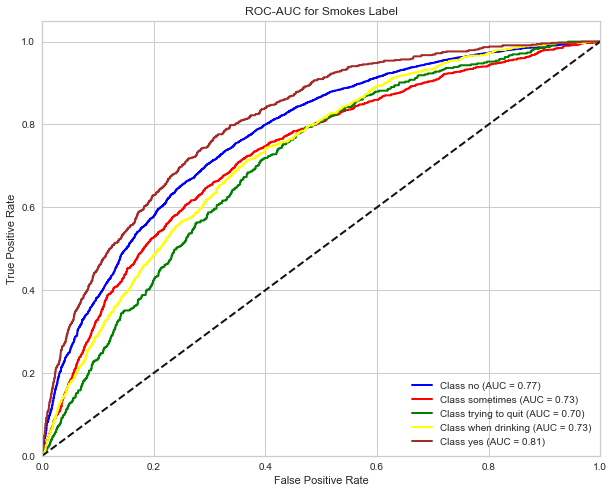

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels
y_test_bin = label_binarize(y_test_fit, classes=best_model_fit.classes_)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(best_model_fit.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], best_model_fit.predict_proba(X_test_fit)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'brown', 'orange'])  # Add more colors if needed

for i, color in zip(range(len(best_model_fit.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {best_model_fit.classes_[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC for Smokes Label')
plt.legend(loc="lower right")
plt.show()

In [41]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=1312)
random_forest_classifier.fit(X_train_fit, y_train_fit)


# Make predictions
rf_predictions = random_forest_classifier.predict(X_test_fit)
rf_f1 = f1_score(y_test_fit, rf_predictions, average='weighted')
print(f'Random Forest Classifier F1 Score: {rf_f1:.2f}')

# Calculate ROC-AUC score for Random Forest Classifier
rf_roc_auc = roc_auc_score(y_test_fit, random_forest_classifier.predict_proba(X_test_fit), multi_class='ovr')
print(f'Random Forest Classifier ROC-AUC Score: {rf_roc_auc:.2f}')

Random Forest Classifier F1 Score: 0.73
Random Forest Classifier ROC-AUC Score: 0.64


In [43]:
contingency_table2 = pd.crosstab(y_test, rf_predictions)
print("\nContingency Table:")
print(contingency_table2)

# Chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table2)
print(f"\nChi-squared value: {chi2:.2f}")
print(f"P-value: {p:.4f}")

# Check the significance level (e.g., 0.05)
alpha = 0.05
print("\nSignificance level:", alpha)

# Check the p-value against the significance level
if p <= alpha:
    print("Reject the null hypothesis. There is a significant relationship between the variables.")
else:
    print("Fail to reject the null hypothesis. There is no significant relationship between the variables.")


Contingency Table:
col_0              no  sometimes  trying to quit  when drinking  yes
smokes                                                              
no              12304        328             115            204  178
sometimes         939         96              27             58   60
trying to quit    377         24              11             23   21
when drinking     726         62              12             38   51
yes               489         59               9             41   77

Chi-squared value: 814.79
P-value: 0.0000

Significance level: 0.05
Reject the null hypothesis. There is a significant relationship between the variables.


In [44]:
max_iter = 10
neighbors  = np.arange(1, max_iter)
test_f1 = np.empty(len(neighbors))
train_f1 = np.empty(len(neighbors))
test_roc_auc = np.empty(len(neighbors))
train_roc_auc = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    #Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=i+1)
    #Train the model using the training sets
    knn.fit(X_train_fit, y_train_fit)
    #Predict the response for test dataset
    test_pred_fit = knn.predict(X_test_fit)
    train_pred_fit = knn.predict(X_train_fit)
    train_f1[i] = f1_score(y_train_fit, train_pred_fit, average='weighted')
    test_f1[i] = f1_score(y_test_fit, test_pred_fit, average='weighted')
    train_roc_auc[i] = roc_auc_score(y_train_fit, knn.predict_proba(X_train_fit), multi_class='ovr')
    test_roc_auc[i] = roc_auc_score(y_test_fit, knn.predict_proba(X_test_fit), multi_class='ovr')

In [45]:
print(confusion_matrix(y_test_fit, test_pred_fit))
print(classification_report(y_test_fit, test_pred_fit, zero_division=0))

[[13055    40     4    18    12]
 [ 1144    20     2     2    12]
 [  444     6     0     2     4]
 [  863    17     0     4     5]
 [  645    18     0     5     7]]
                precision    recall  f1-score   support

            no       0.81      0.99      0.89     13129
     sometimes       0.20      0.02      0.03      1180
trying to quit       0.00      0.00      0.00       456
 when drinking       0.13      0.00      0.01       889
           yes       0.17      0.01      0.02       675

      accuracy                           0.80     16329
     macro avg       0.26      0.21      0.19     16329
  weighted avg       0.68      0.80      0.72     16329



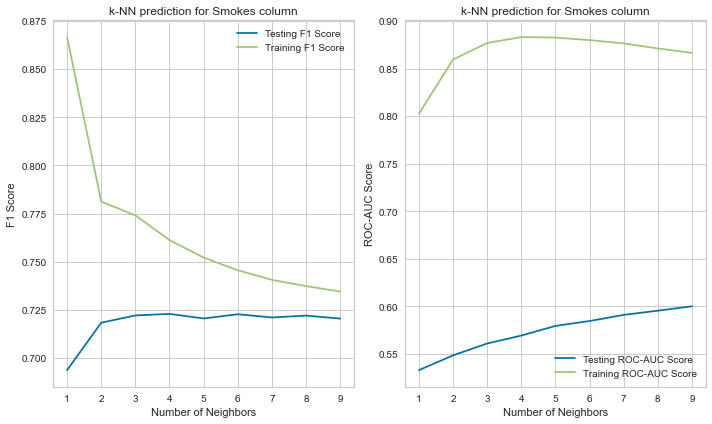

In [54]:
plt.figure(figsize=(10, 6))

# Plotting F1 Scores
plt.subplot(1, 2, 1)
plt.title('k-NN prediction for Smokes column')
plt.plot(neighbors, test_f1, label='Testing F1 Score')
plt.plot(neighbors, train_f1, label='Training F1 Score')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('F1 Score')
plt.savefig('smokes_knn.png', bbox_inches='tight')

# Plotting ROC-AUC Scores
plt.subplot(1, 2, 2)
plt.title('k-NN prediction for Smokes column')
plt.plot(neighbors, test_roc_auc, label='Testing ROC-AUC Score')
plt.plot(neighbors, train_roc_auc, label='Training ROC-AUC Score')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('ROC-AUC Score')

plt.tight_layout()
plt.show()